In [58]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt


In [59]:
train = pd.read_csv("datasets/train.csv.zip", compression="zip")


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop("label", axis=1),
    to_categorical(train["label"], num_classes=10),
    test_size=0.2,
    random_state=1234,
)
X_train = minmax_scale(X_train, feature_range=(-1, 1), axis=1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = minmax_scale(X_test, feature_range=(-1, 1), axis=1)
X_test = X_test.reshape(-1, 28, 28, 1)


In [61]:
model = tf.keras.Sequential()
# model.add(tf.keras.layers.Reshape(input_shape=(784,), target_shape=(28, 28, 1)))

model.add(
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding="same", input_shape=(28, 28, 1))
)
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Dropout(0.3))

model.add(
    tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation="relu", padding="same")
)
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Dropout(0.3))

model.add(
    tf.keras.layers.Conv2D(filters=128, kernel_size=5, activation="relu", padding="same")
)
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95**x)


In [62]:
epochs = 200
hist = model.fit(
    X_train,
    y_train,
    batch_size=80,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[annealer],
    verbose=1,
)


Epoch 1/200
420/420 [==============================] - 42s 98ms/step - loss: 0.3324 - accuracy: 0.8915 - val_loss: 0.0625 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 2/200
420/420 [==============================] - 42s 100ms/step - loss: 0.0832 - accuracy: 0.9741 - val_loss: 0.0460 - val_accuracy: 0.9867 - lr: 9.5000e-04
Epoch 3/200
420/420 [==============================] - 40s 95ms/step - loss: 0.0637 - accuracy: 0.9810 - val_loss: 0.0387 - val_accuracy: 0.9881 - lr: 9.0250e-04
Epoch 4/200
420/420 [==============================] - 43s 102ms/step - loss: 0.0551 - accuracy: 0.9832 - val_loss: 0.0338 - val_accuracy: 0.9910 - lr: 8.5737e-04
Epoch 5/200
420/420 [==============================] - 40s 96ms/step - loss: 0.0440 - accuracy: 0.9865 - val_loss: 0.0297 - val_accuracy: 0.9908 - lr: 8.1451e-04
Epoch 6/200
420/420 [==============================] - 41s 98ms/step - loss: 0.0380 - accuracy: 0.9882 - val_loss: 0.0291 - val_accuracy: 0.9914 - lr: 7.7378e-04
Epoch 7/200
420/420 [=========

In [63]:
datagen = ImageDataGenerator(
    zoom_range=0.15, height_shift_range=0.15, width_shift_range=0.15, rotation_range=15
)
hist = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=epochs,
    callbacks=[annealer],
    verbose=1,
)


Epoch 1/200
525/525 [==============================] - 41s 77ms/step - loss: 0.1983 - accuracy: 0.9433 - lr: 0.0010
Epoch 2/200
525/525 [==============================] - 40s 76ms/step - loss: 0.1059 - accuracy: 0.9689 - lr: 9.5000e-04
Epoch 3/200
525/525 [==============================] - 40s 77ms/step - loss: 0.0906 - accuracy: 0.9732 - lr: 9.0250e-04
Epoch 4/200
525/525 [==============================] - 40s 77ms/step - loss: 0.0836 - accuracy: 0.9759 - lr: 8.5737e-04
Epoch 5/200
525/525 [==============================] - 41s 77ms/step - loss: 0.0737 - accuracy: 0.9784 - lr: 8.1451e-04
Epoch 6/200
525/525 [==============================] - 39s 75ms/step - loss: 0.0660 - accuracy: 0.9800 - lr: 7.7378e-04
Epoch 7/200
525/525 [==============================] - 41s 78ms/step - loss: 0.0639 - accuracy: 0.9802 - lr: 7.3509e-04
Epoch 8/200
525/525 [==============================] - 40s 75ms/step - loss: 0.0612 - accuracy: 0.9828 - lr: 6.9834e-04
Epoch 9/200
525/525 [=======================

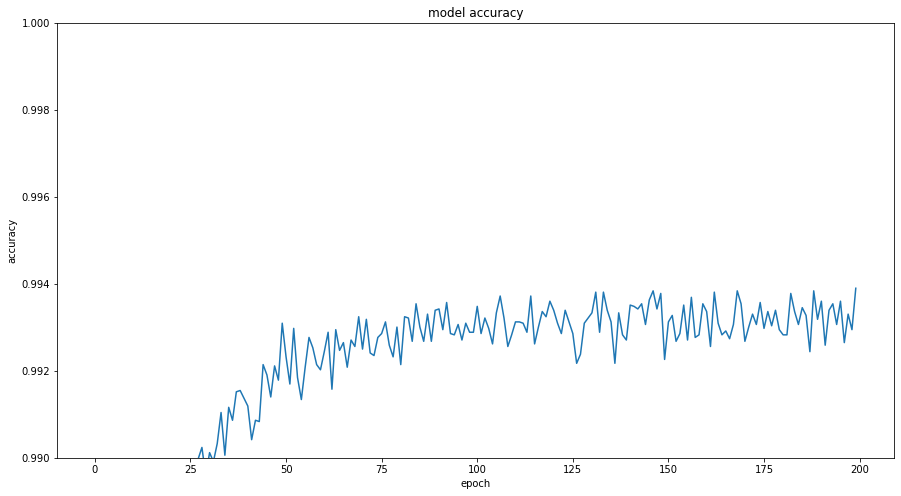

In [66]:
plt.figure(figsize=(15, 8))
plt.plot(hist.history["accuracy"])
plt.title("model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
axes = plt.gca()
axes.set_ylim([0.99, 1])
plt.show()


In [65]:
test = pd.read_csv("datasets/test.csv.zip", compression="zip")
test = minmax_scale(test, feature_range=(-1, 1)).reshape(-1, 28, 28, 1)
results = model.predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name="Label")
submission = pd.concat([pd.Series(range(1, 28001), name="ImageId"), results], axis=1)
submission.to_csv("datasets/submission.csv", index=False)
